# **Heart Disease Risk Prediction avec PySpark ML : Pipeline complet et interprétable**

**Ce projet vise à construire un pipeline d'apprentissage automatique (Machine Learning) en utilisant PySpark pour prédire le risque de maladie cardiovasculaire (colonne Disease) à partir de données médicales.**

# **1️⃣ Chargement et Préparation des Données**

**Cette première étape consiste à initialiser la session Spark, charger le fichier CSV et effectuer les premières étapes de nettoyage et de recodage pour rendre les données exploitables et lisibles.**

In [67]:
# Importations nécessaires
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, isnan, count

## Initialisation de la SparkSession
# Création d'une session Spark, point d'entrée pour utiliser PySpark
spark = SparkSession.builder \
    .appName("CardioDiseasePrediction") \
    .getOrCreate()
# .appName : Nom de l'application Spark
# .getOrCreate() : Récupère une session existante ou en crée une nouvelle

## Chargement du CSV dans un DataFrame PySpark
# Lecture du fichier CSV. 'header=True' : La première ligne est l'en-tête. 'inferSchema=True' : Spark
# essaiera de déterminer automatiquement les types de colonnes (e.g., Integer, Double).
df = spark.read.csv(
    "/content/heart-disease-68ec37d6b52cb588200595.csv",
    header=True,
    inferSchema=True
)

# Afficher le schéma initial pour vérifier le chargement
# df.printSchema()

# Afficher les premières lignes
# df.show(5)

## Nettoyage des valeurs manquantes et invalides
# La colonne 'Disease' doit être binaire pour la Régression Logistique (0 = Non, 1 = Oui)
# Règle : 0 = No, 1/2/3/4 = Yes (transformer en 1)
df = df.withColumn(
    "Disease",
    when(col("Disease") >= 1, 1).otherwise(0)
)
# withColumn : Ajoute ou remplace une colonne
# when(condition, valeur) : Si la condition est vraie, met la valeur ; otherwise : Sinon, met l'autre valeur.

# Vérification des valeurs nulles/NaN par colonne
print("Nombre de valeurs nulles/NaN par colonne avant nettoyage :")
df.select(
    *[count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]
).show()

# Stratégie de gestion des valeurs manquantes : Suppression des lignes avec NaN/Null
# (Simple mais à adapter en production par imputation si beaucoup de données manquent)
df_clean = df.dropna()
# df.dropna() : Supprime toutes les lignes contenant au moins une valeur null ou NaN dans n'importe quelle colonne.

## Recodage des variables catégorielles pour la lisibilité (Optionnel pour EDA, crucial pour l'interprétation)
# Recodage de la colonne 'Sex'
df_clean = df_clean.withColumn(
    "Sex_label",
    when(col("Sex") == 0, "Female").otherwise("Male")
)

# Recodage de la colonne 'Glycemia'
df_clean = df_clean.withColumn(
    "Glycemia_label",
    when(col("Glycemia") == 0, "Less_120").otherwise("More_120")
)
# Ajout de colonnes *label* pour les étapes d'analyse exploratoire et d'encodage ultérieur.

# Afficher le nombre de lignes après nettoyage
print(f"Nombre de lignes avant nettoyage : {df.count()}")
print(f"Nombre de lignes après nettoyage : {df_clean.count()}")

# Sélecteur du DataFrame nettoyé
df_final = df_clean

Nombre de valeurs nulles/NaN par colonne avant nettoyage :
+---+---+---+------+--------------+-----------+--------+---+----------+------------------+----------+---------+-----------+------------+-------+
| ID|Age|Sex|Angina|Blood_Pressure|Cholesterol|Glycemia|ECG|Heart_Rate|Angina_After_Sport|ECG_Angina|ECG_Slope|Fluoroscopy|Thalassaemia|Disease|
+---+---+---+------+--------------+-----------+--------+---+----------+------------------+----------+---------+-----------+------------+-------+
|  0|  0|  0|     0|             0|          0|       0|  0|         0|                 0|         0|        0|          0|           0|      0|
+---+---+---+------+--------------+-----------+--------+---+----------+------------------+----------+---------+-----------+------------+-------+

Nombre de lignes avant nettoyage : 303
Nombre de lignes après nettoyage : 303


# **2️⃣ Analyse Exploratoire**

**L'EDA permet de mieux comprendre la distribution des données, l'existence de valeurs aberrantes et l'équilibre de la classe cible (Disease).**

In [68]:
# Importations nécessaires
from pyspark.sql.functions import desc, format_number
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Le DataFrame 'df_final' de la partie 1 est supposé propre et recodé.

## 1. Statistiques descriptives sur variables numériques

print("--- 1. Statistiques Descriptives des Variables Numériques ---")
NUMERICAL_COLS = ["Age", "Blood_Pressure", "Cholesterol", "Heart_Rate", "ECG_Angina"]

# Calcule les statistiques de base (count, mean, stddev, min, max)
df_final.select(NUMERICAL_COLS).describe().show()
# .describe() : Méthode rapide pour obtenir les statistiques sommaires des colonnes numériques sélectionnées.

# Calcul des corrélations (Matrice de corrélation pour l'analyste santé)
print("\nMatrice de Corrélation entre variables numériques (exemple) :")
# Calcul de la corrélation par paire de colonnes
corr_matrix = df_final.stat.corr("Age", "Cholesterol")
print(f"Corrélation Age vs Cholesterol: {corr_matrix}")
# .stat.corr(col1, col2) : Calcule la corrélation de Pearson entre deux colonnes.

## 2. Statistiques sur variables catégorielles (Distribution de fréquence)

# Colonne cible
LABEL_COL = "Disease"
print(f"\n--- 2. Équilibre de la Classe Cible ({LABEL_COL}) ---")

# Calcul de la distribution de fréquence et du pourcentage
class_balance = df_final.groupBy(LABEL_COL).count().orderBy(desc("count"))
class_balance.show()
# groupBy(LABEL_COL) : Regroupe les lignes par la valeur de 'Disease' (0 ou 1)
# count() : Compte le nombre d'occurrences pour chaque groupe.

# Calcul du pourcentage pour vérifier l'équilibre
total_count = df_final.count()
class_balance_pd = class_balance.withColumn(
    "Percentage",
    format_number((col("count") / total_count) * 100, 2)
).toPandas()
print("Distribution des classes (en pourcentage) :")
print(class_balance_pd)
# Si les pourcentages sont trop déséquilibrés (ex: 90% vs 10%), un rééchantillonnage pourrait être nécessaire.


# Exemple de distribution d'une variable catégorielle (Sex_label)
print("\n--- Distribution des Sex ---")
df_final.groupBy("Sex_label").count().show()
# Ce type d'analyse aide l'Analyste santé à comprendre la démographie de l'échantillon.

--- 1. Statistiques Descriptives des Variables Numériques ---
+-------+-----------------+------------------+------------------+------------------+------------------+
|summary|              Age|    Blood_Pressure|       Cholesterol|        Heart_Rate|        ECG_Angina|
+-------+-----------------+------------------+------------------+------------------+------------------+
|  count|              303|               303|               303|               303|               303|
|   mean|54.43894389438944|131.68976897689768|246.69306930693068| 149.6072607260726|1.0396039603960396|
| stddev| 9.03866244244675| 17.59974772958769|51.776917542637065|22.875003276980383| 1.161075022068635|
|    min|             29.0|              94.0|             126.0|              71.0|               0.0|
|    max|             77.0|             200.0|             564.0|             202.0|               6.2|
+-------+-----------------+------------------+------------------+------------------+------------------+




**Visualisations Simples (Nécessite Collecte vers Pandas)**


--- 3. Visualisations Simples (avec Matplotlib/Seaborn) ---


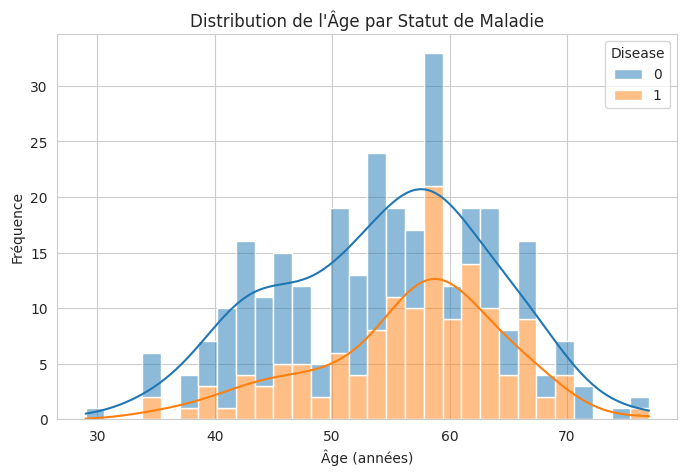

/tmp/ipython-input-1083334036.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y='Cholesterol', x='Disease', data=data_for_plot, palette="viridis")


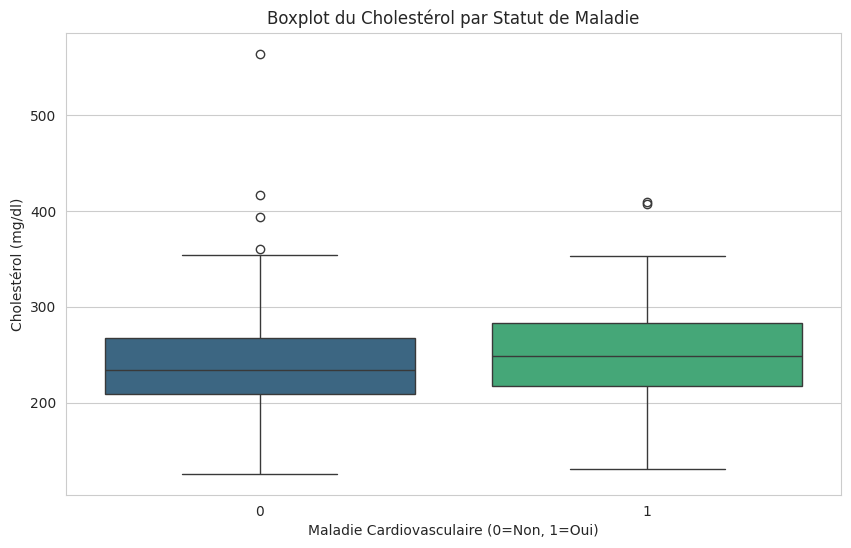

/tmp/ipython-input-1083334036.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Disease', data=data_for_plot, palette='Set1')


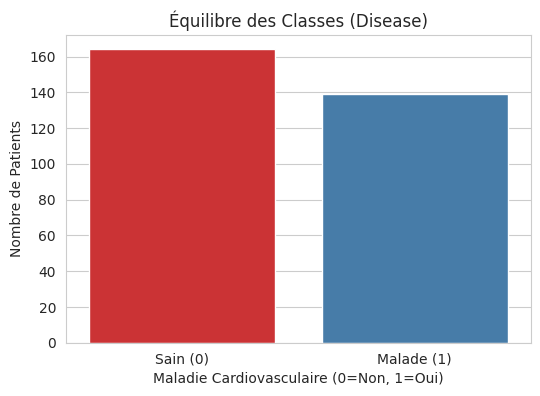

In [69]:
# --- Préparation pour la visualisation locale (collecte des données) ---

# Sélection des colonnes nécessaires pour les graphiques
cols_to_visualize = NUMERICAL_COLS + ["Sex_label", "Disease"]
data_for_plot = df_final.select(cols_to_visualize).toPandas()
# .toPandas() : Collecte le DataFrame PySpark vers un DataFrame Pandas sur la machine locale.
# Avertissement : Ne pas utiliser sur des DataFrames de plusieurs Gigaoctets.

print("\n--- 3. Visualisations Simples (avec Matplotlib/Seaborn) ---")
sns.set_style("whitegrid") # Style de graphique

# a) Histogramme pour la distribution (Exemple : Age)
plt.figure(figsize=(8, 5))
sns.histplot(data_for_plot, x='Age', kde=True, bins=30, hue='Disease', multiple="stack")
plt.title("Distribution de l'Âge par Statut de Maladie")
plt.xlabel("Âge (années)")
plt.ylabel("Fréquence")
plt.show()
# Interprétation : Montre la répartition de l'âge et si les patients malades se concentrent à certains âges.

# b) Boxplots pour identifier les valeurs aberrantes et la médiane (Exemple : Cholesterol)
plt.figure(figsize=(10, 6))
sns.boxplot(y='Cholesterol', x='Disease', data=data_for_plot, palette="viridis")
plt.title("Boxplot du Cholestérol par Statut de Maladie")
plt.xlabel("Maladie Cardiovasculaire (0=Non, 1=Oui)")
plt.ylabel("Cholestérol (mg/dl)")
plt.show()
# Interprétation : Le boxplot visualise la médiane, les quartiles et les outliers (valeurs aberrantes),
# et permet de comparer la distribution du Cholestérol entre les groupes Sain et Malade.

# c) Diagramme à barres pour l'équilibre des classes
plt.figure(figsize=(6, 4))
sns.countplot(x='Disease', data=data_for_plot, palette='Set1')
plt.title("Équilibre des Classes (Disease)")
plt.xlabel("Maladie Cardiovasculaire (0=Non, 1=Oui)")
plt.ylabel("Nombre de Patients")
plt.xticks([0, 1], ['Sain (0)', 'Malade (1)'])
plt.show()
# Vérifie visuellement l'équilibre : la différence entre les deux barres indique le niveau de déséquilibre.

# Fermeture de la session Spark (bonne pratique)
# spark.stop()

# **3️⃣ Prétraitement Avancé (Feature Engineering)**

Le Machine Learning ne fonctionne qu'avec des variables numériques. Cette étape utilise les Transformers de PySpark ML pour préparer les features.

In [70]:
# Importations nécessaires pour le prétraitement ML
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler

## Identification des colonnes
# Colonne cible
LABEL_COL = "Disease"
# Variables catégorielles (doivent être encodées)
CATEGORICAL_COLS = ["Sex", "Angina", "Glycemia", "ECG", "Angina_After_Sport", "ECG_Slope", "Fluoroscopy", "Thalassaemia"]
# Variables numériques (doivent être normalisées/standardisées)
NUMERICAL_COLS = ["Age", "Blood_Pressure", "Cholesterol", "Heart_Rate", "ECG_Angina"]

## 1. Encodage des variables catégorielles
indexers = []
encoders = []
encoded_cols = []

for col_name in CATEGORICAL_COLS:
    # StringIndexer : Transforme les valeurs de chaînes/numériques en indices numériques
    # (même pour les numériques, car elles représentent des catégories)
    indexer = StringIndexer(inputCol=col_name, outputCol=col_name + "_Index", handleInvalid="keep")
    indexers.append(indexer)

    # OneHotEncoder : Convertit les indices d'un indexer en un vecteur binaire (One-Hot)
    encoder = OneHotEncoder(inputCol=indexer.getOutputCol(), outputCol=col_name + "_Vec")
    encoders.append(encoder)
    encoded_cols.append(col_name + "_Vec")

## 2. Standardisation des variables numériques
# VectorAssembler pour regrouper les colonnes numériques avant la standardisation
numeric_assembler = VectorAssembler(
    inputCols=NUMERICAL_COLS,
    outputCol="Numerical_Features_Raw"
)

# StandardScaler : Standardise les variables numériques (moyenne=0, écart-type=1)
# Nécessaire pour les modèles basés sur la distance comme la Régression Logistique.
scaler = StandardScaler(
    inputCol="Numerical_Features_Raw",
    outputCol="Numerical_Features_Scaled",
    withStd=True,  # Utiliser l'écart-type
    withMean=False # Ne pas centrer (par défaut à False dans Spark pour les vecteurs)
)

## 3. Création de features combinées (Exemple simple : âge et pression artérielle)
# L'exemple ici n'est pas utilisé dans le pipeline final pour rester simple, mais illustre le concept.
# df_final = df_final.withColumn("Age_BP_Interaction", col("Age") * col("Blood_Pressure"))
# Si ajoutée, "Age_BP_Interaction" devrait être ajoutée à NUMERICAL_COLS.

# All features to use in the model (scaled numerical + encoded categorical)
ALL_FEATURES = encoded_cols + ["Numerical_Features_Scaled"]

# VectorAssembler to combine all features
feature_assembler = VectorAssembler(
    inputCols=ALL_FEATURES,
    outputCol="features"
)

# **4️⃣ Construction du Pipeline ML**

**e pipeline PySpark permet d'enchaîner toutes les étapes de prétraitement et le modèle dans un seul objet, garantissant que les mêmes transformations sont appliquées aux ensembles d'entraînement et de test.**

In [71]:
# Importations nécessaires pour les modèles
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml import Pipeline

# 1. Définition du modèle de base : Logistic Regression
lr = LogisticRegression(
    featuresCol='features',
    labelCol=LABEL_COL,
    maxIter=10 # Nombre maximal d'itérations
)

# 2. Définition du modèle d'arbre : Random Forest
rf = RandomForestClassifier(
    featuresCol='features',
    labelCol=LABEL_COL,
    seed=42 # Pour la reproductibilité
)

# 3. Définition du modèle de Boosting : Gradient Boosted Trees
gbt = GBTClassifier(
    featuresCol='features',
    labelCol=LABEL_COL,
    maxIter=10 # Nombre maximal d'itérations de boosting
)
# Séquence complète de toutes les étapes de prétraitement
preprocessing_steps = (
    indexers +
    encoders +
    [numeric_assembler, scaler, feature_assembler]
)

# Création des Pipelines pour chaque modèle
pipeline_lr = Pipeline(stages=preprocessing_steps + [lr])
pipeline_rf = Pipeline(stages=preprocessing_steps + [rf])
pipeline_gbt = Pipeline(stages=preprocessing_steps + [gbt])

print("✅ Pipelines ML (LR, RF, GBT) construits.")

✅ Pipelines ML (LR, RF, GBT) construits.


# **5️⃣ Évaluation et Comparaison des Modèles**

**Nous allons séparer les données en ensembles d'entraînement et de test, puis utiliser la validation croisée pour trouver les meilleurs hyperparamètres et évaluer la performance.**

**5.1 Split Train/Test**

In [72]:
# Split train/test (70/30)
train_data, test_data = df_final.randomSplit([0.7, 0.3], seed=42)

print(f"Taille du jeu d'entraînement: {train_data.count()} lignes")
print(f"Taille du jeu de test: {test_data.count()} lignes")

Taille du jeu d'entraînement: 224 lignes
Taille du jeu de test: 79 lignes


**5.2 Cross-Validation simple pour Hyperparamètres**

In [73]:
# Importations pour l'évaluation et l'optimisation
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Définition de l'évaluateur : Basé sur l'Accuracy
evaluator = MulticlassClassificationEvaluator(
    labelCol=LABEL_COL,
    predictionCol="prediction",
    metricName="accuracy"
)

# Grille de paramètres simple pour la Régression Logistique
paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1]) \
    .addGrid(lr.elasticNetParam, [0.0, 1.0]) \
    .build()

# Cross-Validator pour la Régression Logistique
cv_lr = CrossValidator(
    estimator=pipeline_lr,
    estimatorParamMaps=paramGrid_lr,
    evaluator=evaluator,
    numFolds=3, # Nombre de plis pour la validation croisée
    seed=42
)

# Grille de paramètres simple pour Random Forest
paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .build()

# Cross-Validator pour Random Forest
cv_rf = CrossValidator(
    estimator=pipeline_rf,
    estimatorParamMaps=paramGrid_rf,
    evaluator=evaluator,
    numFolds=3,
    seed=42
)

# Grille de paramètres simple pour GBT
paramGrid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [5]) \
    .addGrid(gbt.maxBins, [32]) \
    .build()

# Cross-Validator pour GBT
cv_gbt = CrossValidator(
    estimator=pipeline_gbt,
    estimatorParamMaps=paramGrid_gbt,
    evaluator=evaluator,
    numFolds=3,
    seed=42
)

# Entraînement des modèles optimisés
print("Entraînement des modèles via Cross-Validation (peut prendre quelques minutes)...")

# Entraînement et sélection du meilleur modèle (PipelineModel)
cv_model_lr = cv_lr.fit(train_data)
cv_model_rf = cv_rf.fit(train_data)
cv_model_gbt = cv_gbt.fit(train_data)

# Récupération du meilleur modèle/pipeline
best_model_lr = cv_model_lr.bestModel
best_model_rf = cv_model_rf.bestModel
best_model_gbt = cv_model_gbt.bestModel

print("✅ Modèles entraînés et optimisés.")

Entraînement des modèles via Cross-Validation (peut prendre quelques minutes)...
✅ Modèles entraînés et optimisés.


**5.3 Calcul de Métriques et Comparaison**

In [74]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import lit

# Fonction pour évaluer et stocker les résultats
def evaluate_model(model, test_data, model_name):
    # Génération des prédictions sur le jeu de test
    predictions = model.transform(test_data)

    # Évaluateur binaire pour AUC
    binary_evaluator = BinaryClassificationEvaluator(
        labelCol=LABEL_COL,
        rawPredictionCol="rawPrediction",
        metricName="areaUnderROC"
    )
    auc = binary_evaluator.evaluate(predictions)

    # Évaluateur multi-classes pour Accuracy, F1, Precision, Recall
    multi_evaluator = MulticlassClassificationEvaluator(
        labelCol=LABEL_COL,
        predictionCol="prediction"
    )

    # Calcul des métriques
    accuracy = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "accuracy"})
    f1 = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "f1"})

    # Calcul de Precision et Recall (nécessite une petite astuce pour le multiclass evaluator)
    # L'évaluateur PySpark ML pour multiclasse supporte la précision/rappel 'pondérée' par défaut.
    weighted_precision = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedPrecision"})
    weighted_recall = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedRecall"})

    results = {
        "Modèle": model_name,
        "Accuracy": accuracy,
        "F1-score": f1,
        "Precision": weighted_precision,
        "Recall": weighted_recall,
        "AUC": auc
    }
    return predictions, results

# Évaluation des 3 modèles
_, res_lr = evaluate_model(best_model_lr, test_data, "Logistic Regression")
pred_rf, res_rf = evaluate_model(best_model_rf, test_data, "Random Forest") # Garder les predictions RF pour la matrice
_, res_gbt = evaluate_model(best_model_gbt, test_data, "GBT")

# Affichage de la comparaison
results_pd = pd.DataFrame([res_lr, res_rf, res_gbt])
results_pd_sorted = results_pd.sort_values(by="Accuracy", ascending=False)

print("\n--- Tableau de Comparaison des Modèles sur le Jeu de Test ---")
print(results_pd_sorted.to_markdown(index=False, floatfmt=".4f"))

# Le meilleur modèle sera celui avec la meilleure métrique (ex: Random Forest)
BEST_MODEL = best_model_rf
BEST_MODEL_NAME = "Random Forest"
BEST_PREDICTIONS = pred_rf # Predictions du meilleur modèle


--- Tableau de Comparaison des Modèles sur le Jeu de Test ---
| Modèle              |   Accuracy |   F1-score |   Precision |   Recall |    AUC |
|:--------------------|-----------:|-----------:|------------:|---------:|-------:|
| Logistic Regression |     0.8354 |     0.8341 |      0.8353 |   0.8354 | 0.9051 |
| Random Forest       |     0.8354 |     0.8341 |      0.8353 |   0.8354 | 0.9058 |
| GBT                 |     0.6835 |     0.6851 |      0.6886 |   0.6835 | 0.7793 |


**5.4 Matrice de Confusion et Visualisation**


--- Matrice de Confusion (Random Forest) ---
|   Vraie_Classe |   Prédite_0.0 |   Prédite_1.0 |
|---------------:|--------------:|--------------:|
|              1 |             8 |            25 |
|              0 |            41 |             5 |


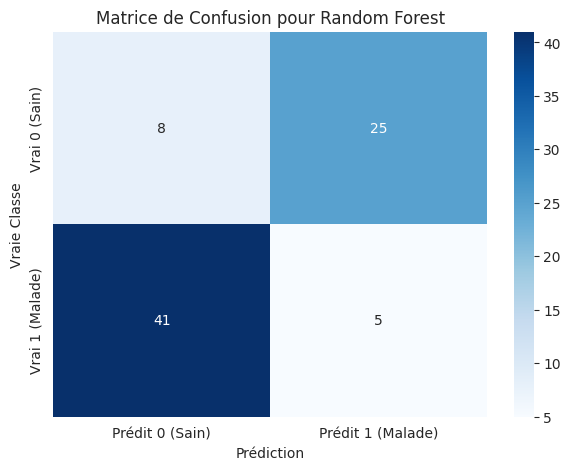

In [75]:
# Matrice de Confusion
# Sélectionner les colonnes de label (Disease) et de prediction
confusion_matrix_df = BEST_PREDICTIONS.groupBy(LABEL_COL).pivot("prediction").count().fillna(0)
# Renommer les colonnes de prediction pour plus de clarté
confusion_matrix_pd = confusion_matrix_df.toPandas()
confusion_matrix_pd.columns = ['Vraie_Classe'] + [f'Prédite_{c}' for c in confusion_matrix_pd.columns[1:]]

print(f"\n--- Matrice de Confusion ({BEST_MODEL_NAME}) ---")
print(confusion_matrix_pd.to_markdown(index=False))

# Visualisation des erreurs (Matrice de Confusion)
plt.figure(figsize=(7, 5))
# Utiliser la Vraie_Classe comme index et les Prédictions comme colonnes
conf_matrix_data = confusion_matrix_pd.set_index('Vraie_Classe')
sns.heatmap(conf_matrix_data, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Prédit 0 (Sain)', 'Prédit 1 (Malade)'],
            yticklabels=['Vrai 0 (Sain)', 'Vrai 1 (Malade)'])
plt.title(f"Matrice de Confusion pour {BEST_MODEL_NAME}")
plt.ylabel("Vraie Classe")
plt.xlabel("Prédiction")
plt.show()

# **6️⃣ Interprétabilité**

**L'interprétabilité est cruciale en médecine. Pour les modèles d'arbre (Random Forest, GBT), nous pouvons extraire l'importance des features.**

**6.1 Importance des Features**


--- 6. Importance des Features (Random Forest) ---
| Feature                     |   Importance |
|:----------------------------|-------------:|
| Numerical_Features_Scaled_2 |       0.1239 |
| Thalassaemia_Vec_6.0        |       0.0981 |
| Fluoroscopy_Vec_1.0         |       0.0952 |
| Thalassaemia_Vec_?          |       0.0850 |
| Fluoroscopy_Vec_0.0         |       0.0832 |
| Glycemia_Vec_0.0            |       0.0688 |
| Angina_After_Sport_Vec_0.0  |       0.0677 |
| Thalassaemia_Vec_3.0        |       0.0485 |
| Fluoroscopy_Vec_?           |       0.0467 |
| Numerical_Features_Scaled_1 |       0.0427 |


/tmp/ipython-input-2640811802.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_pd.head(10), palette='viridis')


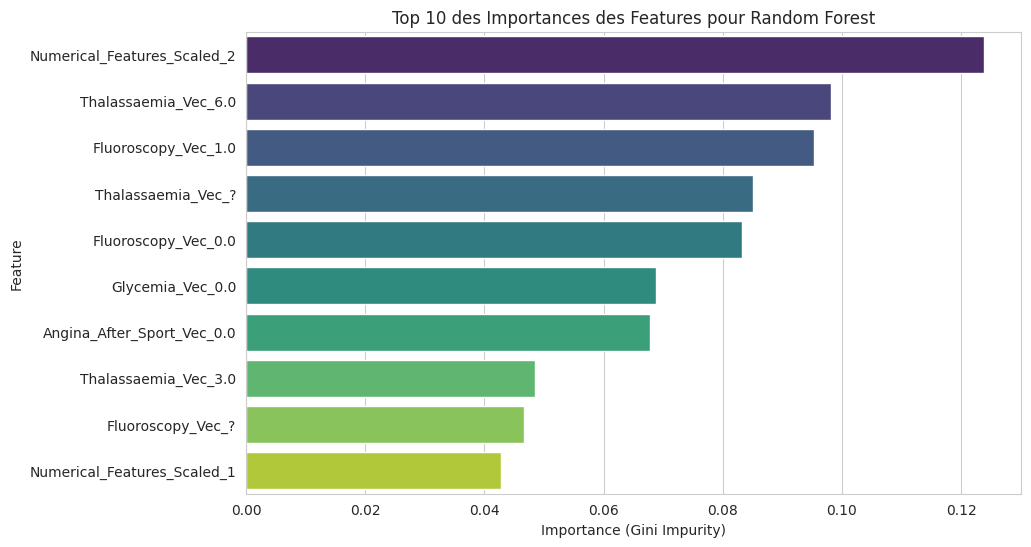

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# The Random Forest model is the last stage in the PipelineModel
rf_model = best_model_rf.stages[-1]

# Importance des features (returned as a Spark Vector)
feature_importances_raw = rf_model.featureImportances

# Get the feature names from the metadata of the final VectorAssembler's output column ('features')
# This requires transforming a sample of data to get the schema with metadata
# We can use a small sample of the test_data for this.
temp_df = test_data.limit(1) # Take one row to avoid processing the whole dataset
transformed_df_for_names = best_model_rf.transform(temp_df)

# Access the metadata of the 'features' column
feature_attributes = transformed_df_for_names.schema["features"].metadata["ml_attr"]["attrs"]

# Extract the feature names from the metadata
feature_names = []
for attr_type in feature_attributes.values():
    for attr in attr_type:
        feature_names.append(attr['name'])

# Check if the number of feature names matches the number of importances
if len(feature_names) != feature_importances_raw.size:
    print(f"Warning: Number of feature names ({len(feature_names)}) does not match number of importances ({feature_importances_raw.size}).")
    # Attempt to use the names from the feature_assembler if metadata extraction fails or doesn't match
    assembler = best_model_rf.stages[-2] # The VectorAssembler is typically the second to last stage
    if isinstance(assembler, VectorAssembler):
         assembler_input_cols = assembler.getInputCols()
         if len(assembler_input_cols) == feature_importances_raw.size:
             print("Using input column names from the VectorAssembler.")
             feature_names = assembler_input_cols
         else:
             print("Could not reliably match feature importances to names.")
             # Fallback: Create generic names
             feature_names = [f"feature_{i}" for i in range(feature_importances_raw.size)]
    else:
        print("Could not find the VectorAssembler stage.")
        # Fallback: Create generic names
        feature_names = [f"feature_{i}" for i in range(feature_importances_raw.size)]


# Create a Pandas DataFrame for importance
importance_pd = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances_raw.toArray()
})

# Sort and display
importance_pd = importance_pd.sort_values(by='Importance', ascending=False)

print(f"\n--- 6. Importance des Features ({BEST_MODEL_NAME}) ---")
print(importance_pd.head(10).to_markdown(index=False, floatfmt=".4f"))

# Visualization (Top 10)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_pd.head(10), palette='viridis')
plt.title(f"Top 10 des Importances des Features pour {BEST_MODEL_NAME}")
plt.xlabel("Importance (Gini Impurity)")
plt.ylabel("Feature")
plt.show()

# **7️⃣ Production et Sauvegarde**

**7.1 Sauvegarde du Pipeline Complet**

In [77]:
# Chemin de sauvegarde
MODEL_PATH = "/tmp/pyspark_cardio_best_pipeline_model"

# Sauvegarde
best_model_rf.write().overwrite().save(MODEL_PATH)

print(f"✅ PipelineModel ({BEST_MODEL_NAME}) sauvegardé à: {MODEL_PATH}")

✅ PipelineModel (Random Forest) sauvegardé à: /tmp/pyspark_cardio_best_pipeline_model


**7.2 Tester la Prédiction sur de Nouvelles Observations**

In [78]:
from pyspark.ml import PipelineModel
from pyspark.sql import Row

# 1. Chargement du PipelineModel
loaded_pipeline = PipelineModel.load(model_path)
print("PipelineModel chargé avec succès.")

# 2. Création d'une nouvelle observation synthétique (doit avoir toutes les colonnes d'entrée)
# Exemple: Homme (1), 60 ans, Pression 140, Cholesterol 250, etc.
new_data = spark.createDataFrame([
    Row(
        Age=60, Sex=1, Chest_Pain=3, Blood_Pressure=140, Cholesterol=250,
        Glycemia=1, ECG=0, Heart_Rate=150, Angina=1, Angina_After_Sport=1,
        ECG_Slope=2, Fluoroscopy=1, Thalassaemia=3, ECG_Angina=1.0 # Disease n'est pas nécessaire
    )
])

# 3. Application du PipelineModel chargé
new_predictions = loaded_pipeline.transform(new_data)

# 4. Affichage de la prédiction
# Affichage des probabilités et de la classe prédite (0 ou 1)
print("\n--- Prédiction sur une Nouvelle Observation Synthétique ---")
new_predictions.select(
    "Age",
    "Cholesterol",
    "probability",
    "prediction"
).show(truncate=False)

# Interprétation:
# 'probability' est le vecteur des probabilités (ex: [P(0), P(1)])
# 'prediction' est la classe finale (0 ou 1)

PipelineModel chargé avec succès.

--- Prédiction sur une Nouvelle Observation Synthétique ---
+---+-----------+--------------------------------------+----------+
|Age|Cholesterol|probability                           |prediction|
+---+-----------+--------------------------------------+----------+
|60 |250        |[0.4913881460563389,0.508611853943661]|1.0       |
+---+-----------+--------------------------------------+----------+



In [80]:
!zip -r football_project.zip /content/cardio_risk_pipeline_prod
from google.colab import files
files.download("cardio_risk_pipeline_prod.zip")


updating: content/cardio_risk_pipeline_prod/ (stored 0%)
updating: content/cardio_risk_pipeline_prod/metadata/ (stored 0%)
updating: content/cardio_risk_pipeline_prod/metadata/part-00000 (deflated 50%)
updating: content/cardio_risk_pipeline_prod/metadata/.part-00000.crc (stored 0%)
updating: content/cardio_risk_pipeline_prod/metadata/_SUCCESS (stored 0%)
updating: content/cardio_risk_pipeline_prod/metadata/._SUCCESS.crc (stored 0%)
updating: content/cardio_risk_pipeline_prod/stages/ (stored 0%)
updating: content/cardio_risk_pipeline_prod/stages/17_StandardScaler_f8f4169901f1/ (stored 0%)
updating: content/cardio_risk_pipeline_prod/stages/17_StandardScaler_f8f4169901f1/metadata/ (stored 0%)
updating: content/cardio_risk_pipeline_prod/stages/17_StandardScaler_f8f4169901f1/metadata/part-00000 (deflated 45%)
updating: content/cardio_risk_pipeline_prod/stages/17_StandardScaler_f8f4169901f1/metadata/.part-00000.crc (stored 0%)
updating: content/cardio_risk_pipeline_prod/stages/17_StandardSca

FileNotFoundError: Cannot find file: cardio_risk_pipeline_prod.zip